In [1]:
!pip install lime

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
import os
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
from scipy.stats import norm
import torch
from lime import lime_image

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Код для обучения модели

In [4]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))

    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [5]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total

In [6]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                    model=model,
                    loss_function=loss_function,
                    optimizer=optima,
                    callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})

# Задача 1

### Модель

In [8]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, layers):
        super(CNN, self).__init__()

        self.layers = layers

    def forward(self, input):
        return self.layers(input)

### Выборка

In [9]:
EMNIST_train = datasets.EMNIST('./emnist', split="letters", train=True, download=True,
                             transform=transforms.ToTensor())

EMNIST_test = datasets.EMNIST('./emnist', split="letters", train=False, download=True,
                            transform=transforms.ToTensor())

In [10]:
class_labels = EMNIST_test.classes
print(class_labels)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [11]:
def approx_loss(model, EMNIST_test):
  batch_generator = torch.utils.data.DataLoader(dataset=EMNIST_test,
                                                shuffle=True,
                                                batch_size=64)

  pred = []
  real = []
  test_loss = 0
  for it, (x_batch, y_batch) in enumerate(batch_generator):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      output = model(x_batch)

      test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

      pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
      real.extend(y_batch.cpu().numpy().tolist())

  test_loss /= len(EMNIST_test)

  print('loss: {}'.format(test_loss))
  return x_batch                                                                # last batch?

In [13]:
def show_layers(x, y, z):

  fig = plt.figure(figsize=(30, 7))
  gs = gridspec.GridSpec(5, 23)
  ax = np.empty([5, 23], dtype=object)
  for i in range(5):
      for j in range(23):
          ax[i][j] = fig.add_subplot(gs[i, j])
  for i in range(len(x)):
      ax[i][0].imshow(x.cpu().data[i, 0].numpy())
      ax[i][0].axis("off")
      for j in range(1, 7):
          ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
          ax[i][j].axis("off")

      for j in range(7, 23):
          ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
          ax[i][j].axis("off")

### Инициализация модели

In [14]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 5))
layers.add_module('relu1', torch.nn.ReLU())
#layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 5))
layers.add_module('relu2', torch.nn.ReLU())
#layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(16*4*100, 120))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model0 = CNN(layers)
model0.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=6400, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )
)

### Качество аппроксимации до обучения

In [15]:
x_batch = approx_loss(model0, EMNIST_test)

loss: 3.3006209820967456


### Визуализация каждого слоя сверточной нейросети

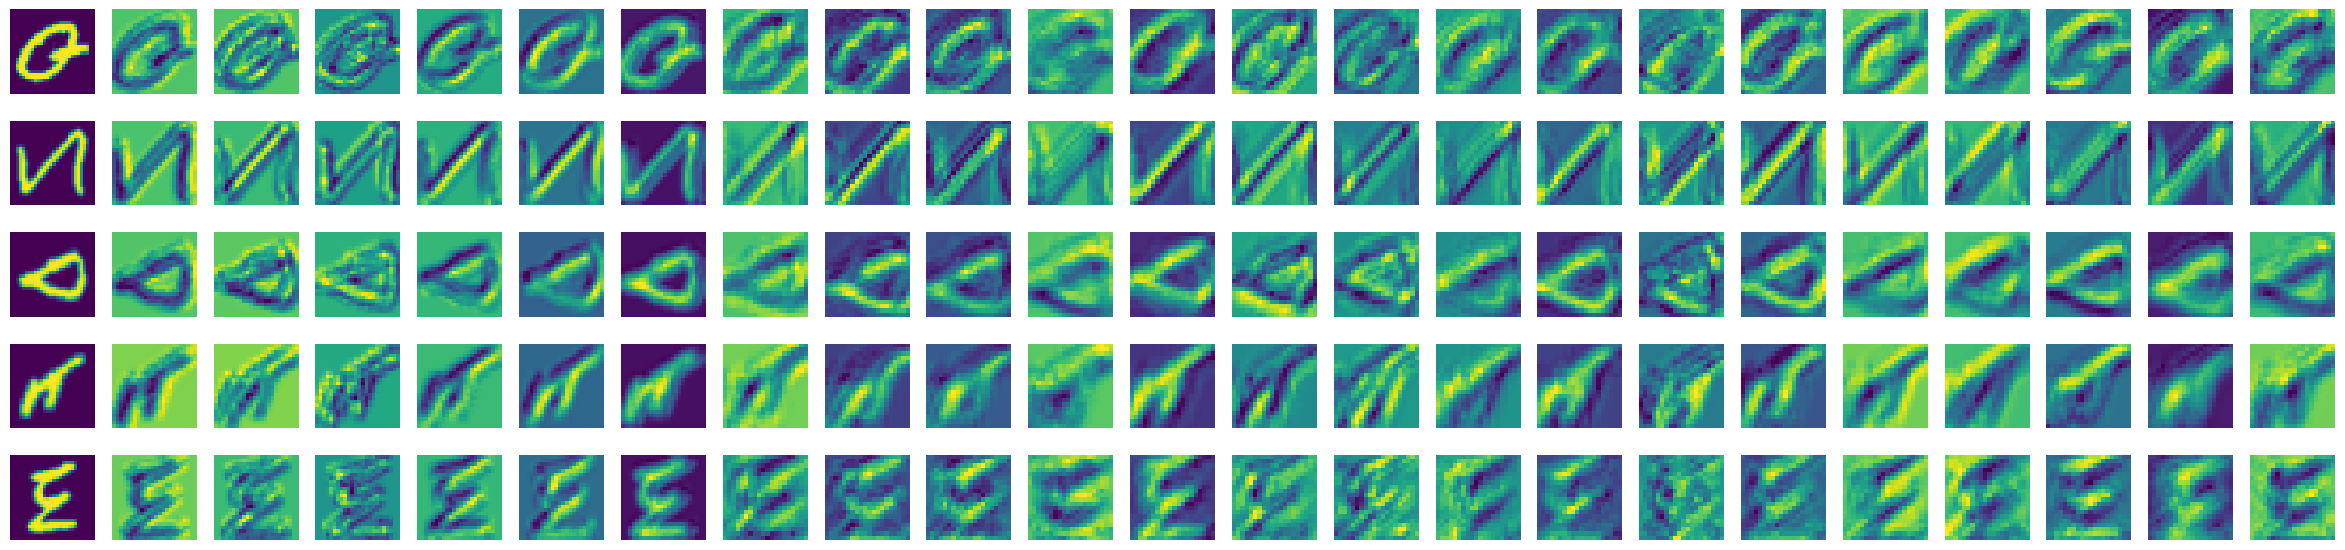

In [16]:
x = x_batch[-5:]
y = model0.layers.conv1(x)
z = model0.layers.conv2(model0.layers.relu1(y))

show_layers(x, y, z)

### Обучение модели

In [17]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model0,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

### Качество аппроксимации после обучения **model0**

In [18]:
x_batch = approx_loss(model0, EMNIST_test)

loss: 0.3093840611439485


### Визуализация каждого слоя сверточной нейросети **model0**

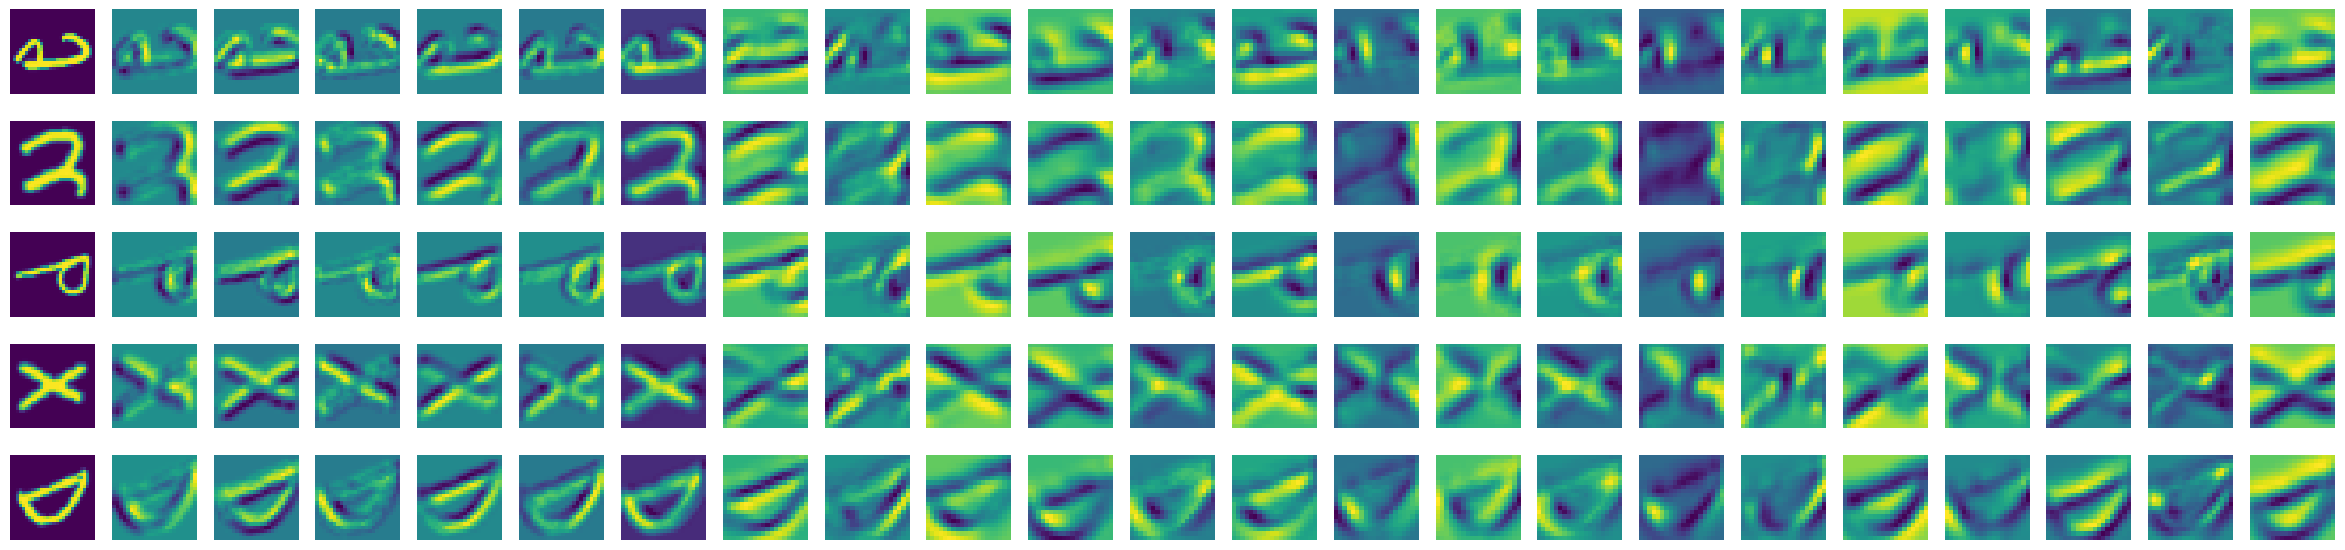

In [19]:
x = x_batch[-5:]
y = model0.layers.conv1(x)
z = model0.layers.conv2(model0.layers.relu1(y))

show_layers(x, y, z)

## Модель 1
Увеличено количество сверток, так как я не уверена в чем цель, я просто добавила сверток... каких-то, наугад (но зато не забыла про необходимость функции активации после них!).



In [20]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 5))
layers.add_module('relu1', torch.nn.ReLU())
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 5))
layers.add_module('relu2', torch.nn.ReLU())
layers.add_module('conv3', torch.nn.Conv2d(1*16, 2*16, kernel_size = 5))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('conv4', torch.nn.Conv2d(2*16, 3*16, kernel_size = 5))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(6912, 120))
layers.add_module('relu5', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu6', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model1 = CNN(layers)
model1.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (conv4): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (relu4): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=6912, out_features=120, bias=True)
    (relu5): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )
)

In [21]:
x_batch = approx_loss(model1, EMNIST_test)

loss: 3.3013382985041693


## Картиночки до обучения, model1

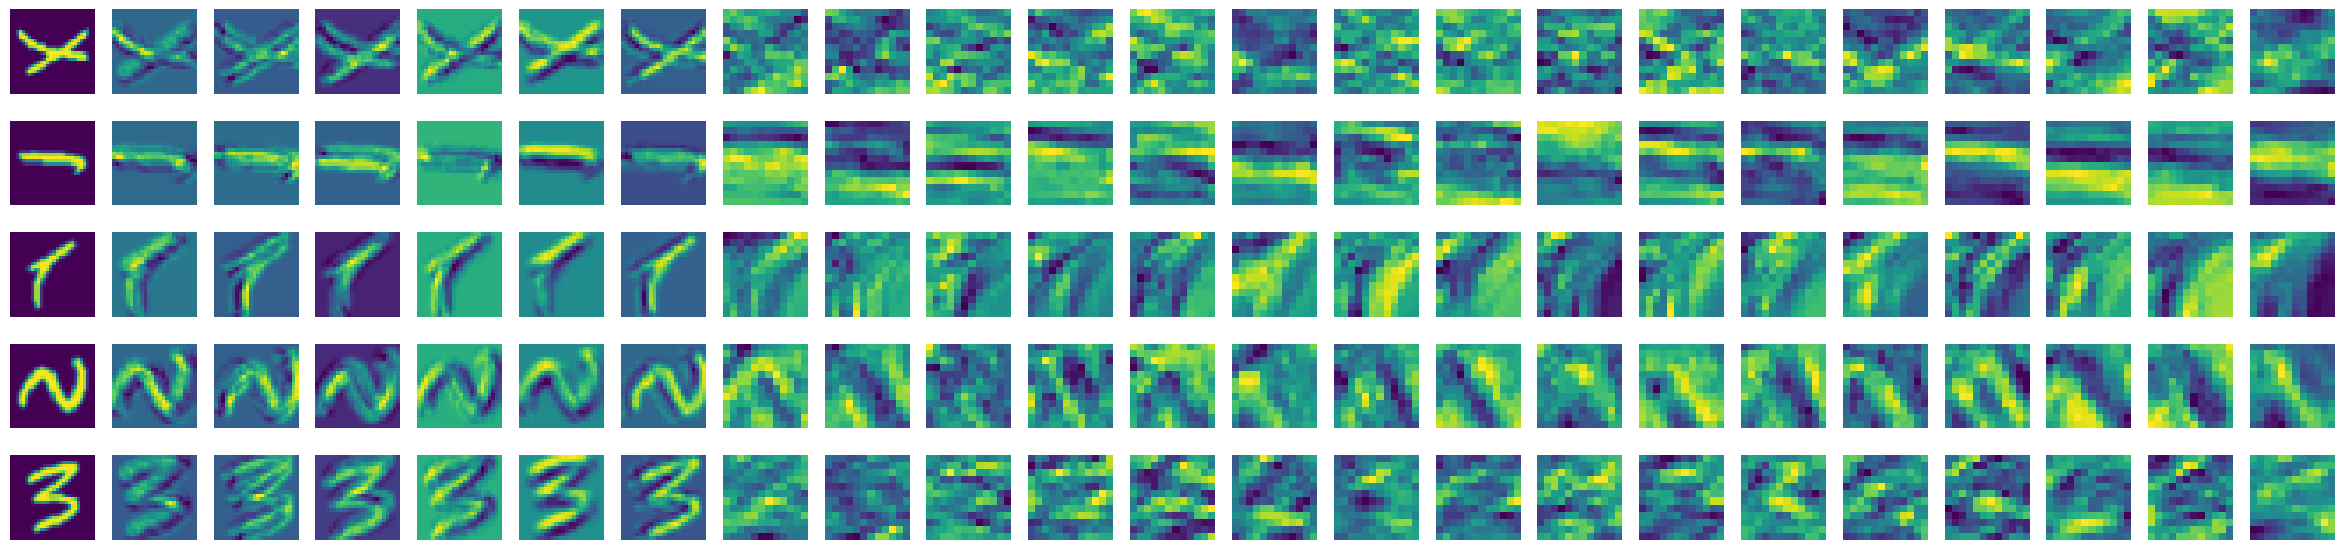

In [22]:
x = x_batch[-5:]
y = model1.layers.conv1(x)
z = model1.layers.conv4(model1.layers.relu3(model1.layers.conv3(model1.layers.relu3(model1.layers.conv2(model1.layers.relu2(y))))))

show_layers(x, y, z)

In [23]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model1,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

In [24]:
x_batch = approx_loss(model1, EMNIST_test)

loss: 0.3133860742816558


## Картиночки после обучения, model1


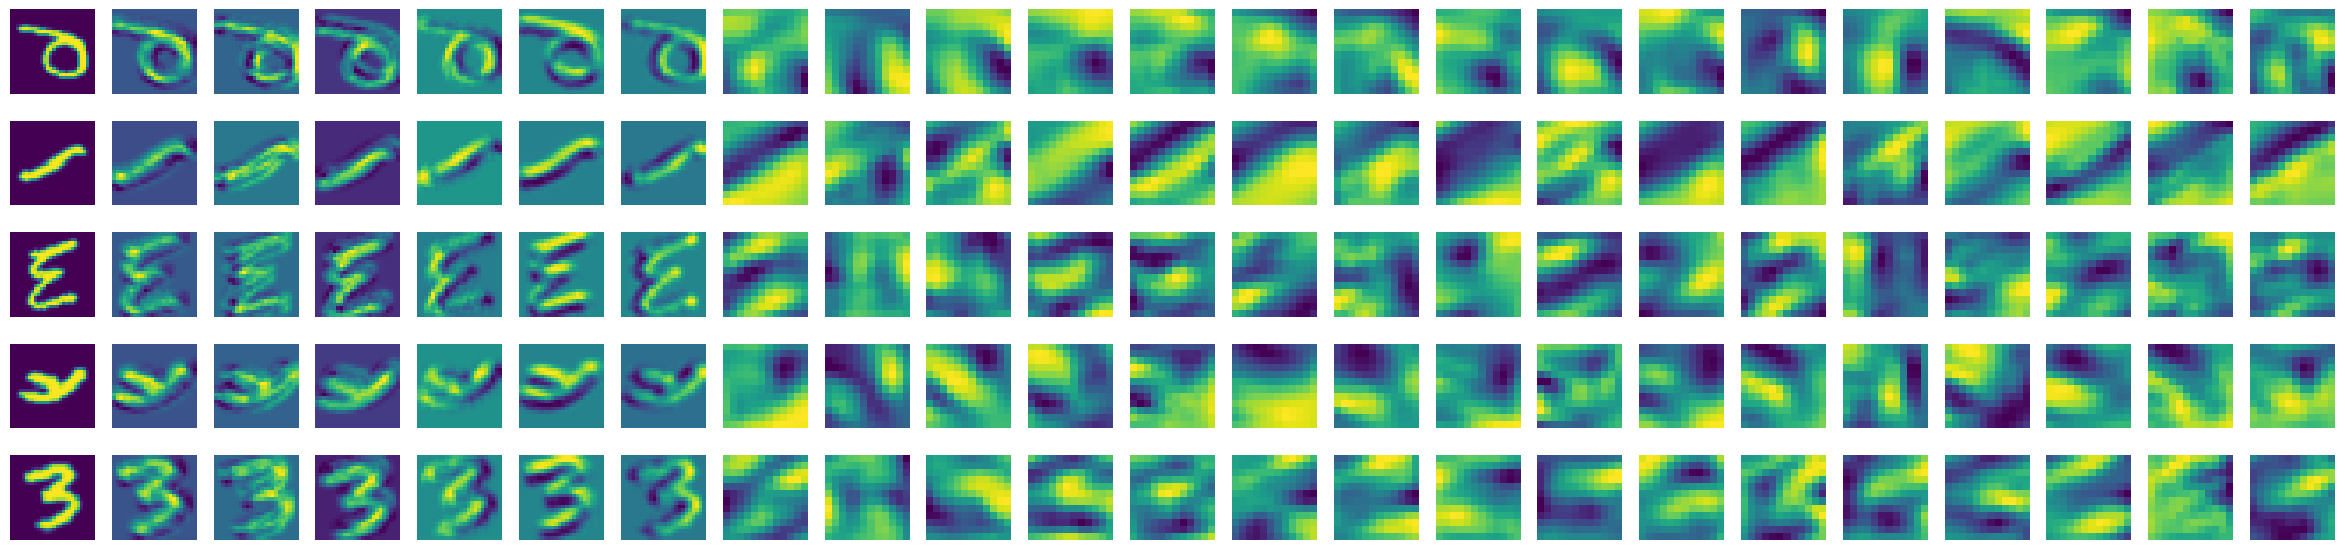

In [25]:
x = x_batch[-5:]
y = model1.layers.conv1(x)
z = model1.layers.conv4(model1.layers.relu3(model1.layers.conv3(model1.layers.relu3(model1.layers.conv2(model1.layers.relu2(y))))))

show_layers(x, y, z)

## Модель 2
Изменен размер ядра.



In [26]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 3))
layers.add_module('relu1', torch.nn.ReLU())
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 3))
layers.add_module('relu2', torch.nn.ReLU())
layers.add_module('conv3', torch.nn.Conv2d(1*16, 2*16, kernel_size = 3))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(15488, 120))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu5', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model2 = CNN(layers)
model2.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=15488, out_features=120, bias=True)
    (relu4): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu5): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )
)

In [27]:
x_batch = approx_loss(model2, EMNIST_test)

loss: 3.302133514697735


## Картиночки до обучения, model2

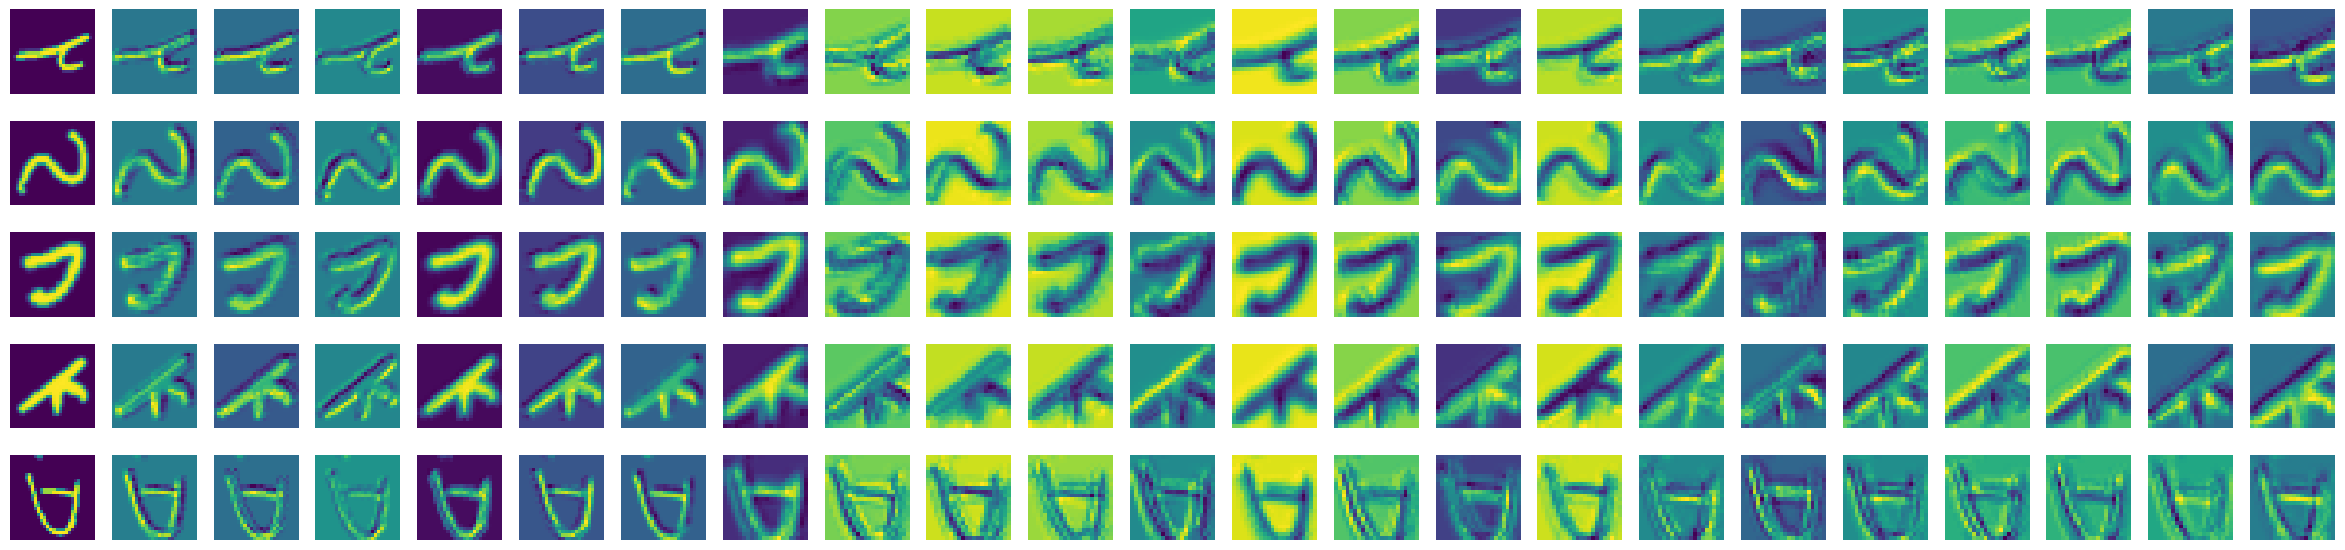

In [28]:
x = x_batch[-5:]
y = model2.layers.conv1(x)
z = model2.layers.conv3(model2.layers.relu2(model2.layers.conv2(model2.layers.relu1(y))))

show_layers(x, y, z)

In [29]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model2,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

In [30]:
x_batch = approx_loss(model2, EMNIST_test)

loss: 0.29117110513723815


## Картиночки после обучения, model2


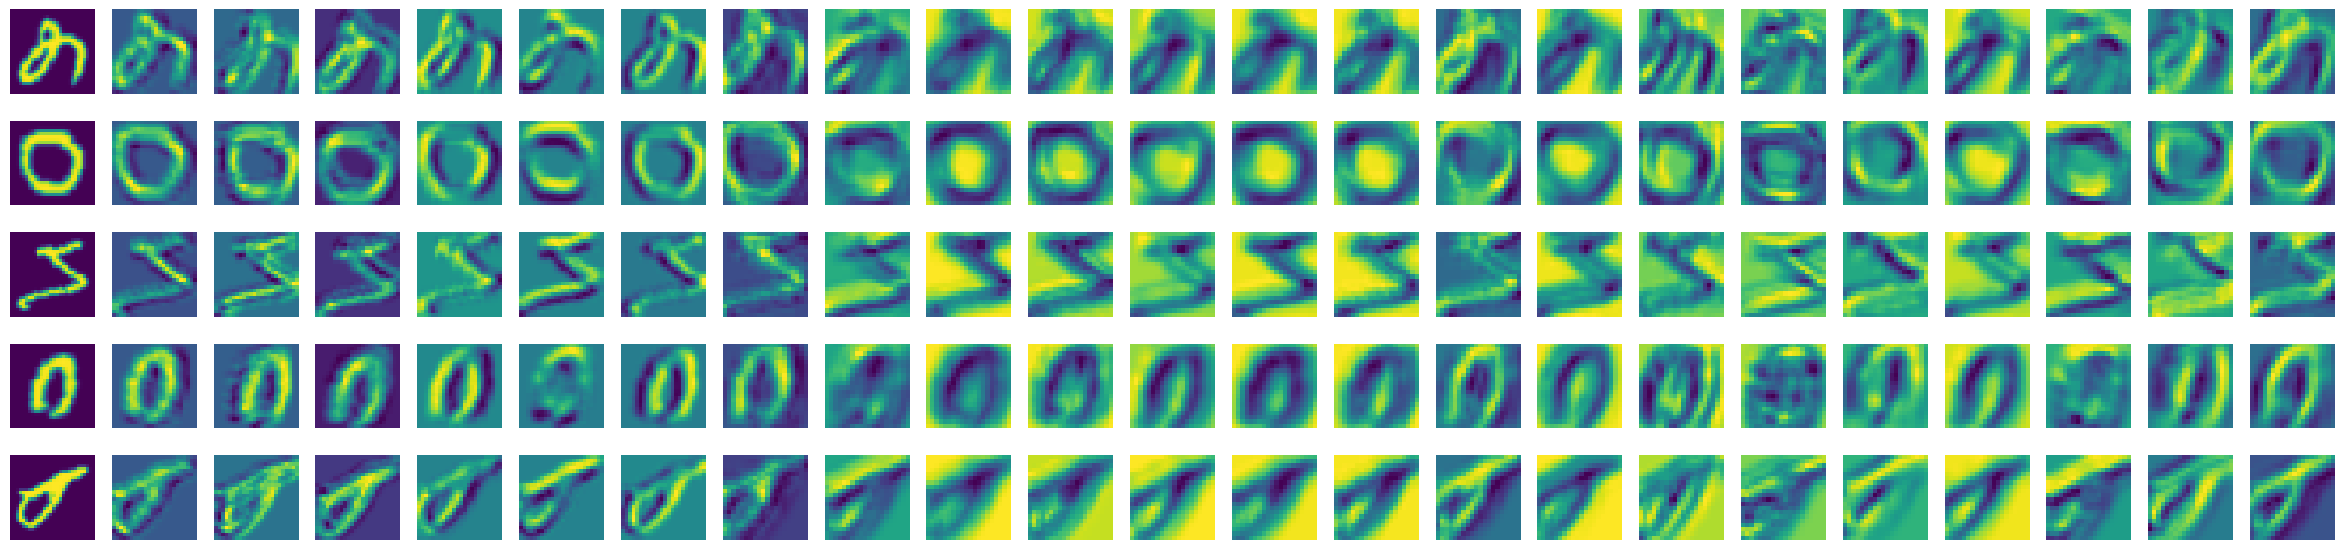

In [31]:
x = x_batch[-5:]
y = model1.layers.conv1(x)
z = model2.layers.conv3(model2.layers.relu2(model2.layers.conv2(model2.layers.relu1(y))))

show_layers(x, y, z)

## Модель 3
Добавим maxpolling между слоями.



In [34]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 5))
layers.add_module('relu1', torch.nn.ReLU())
layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 5))
layers.add_module('relu2', torch.nn.ReLU())
layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(16*4*4, 120))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model3 = CNN(layers)
model3.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=256, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )
)

In [35]:
x_batch = approx_loss(model3, EMNIST_test)

loss: 3.2972499693357027


## Картиночки до обучения, model3

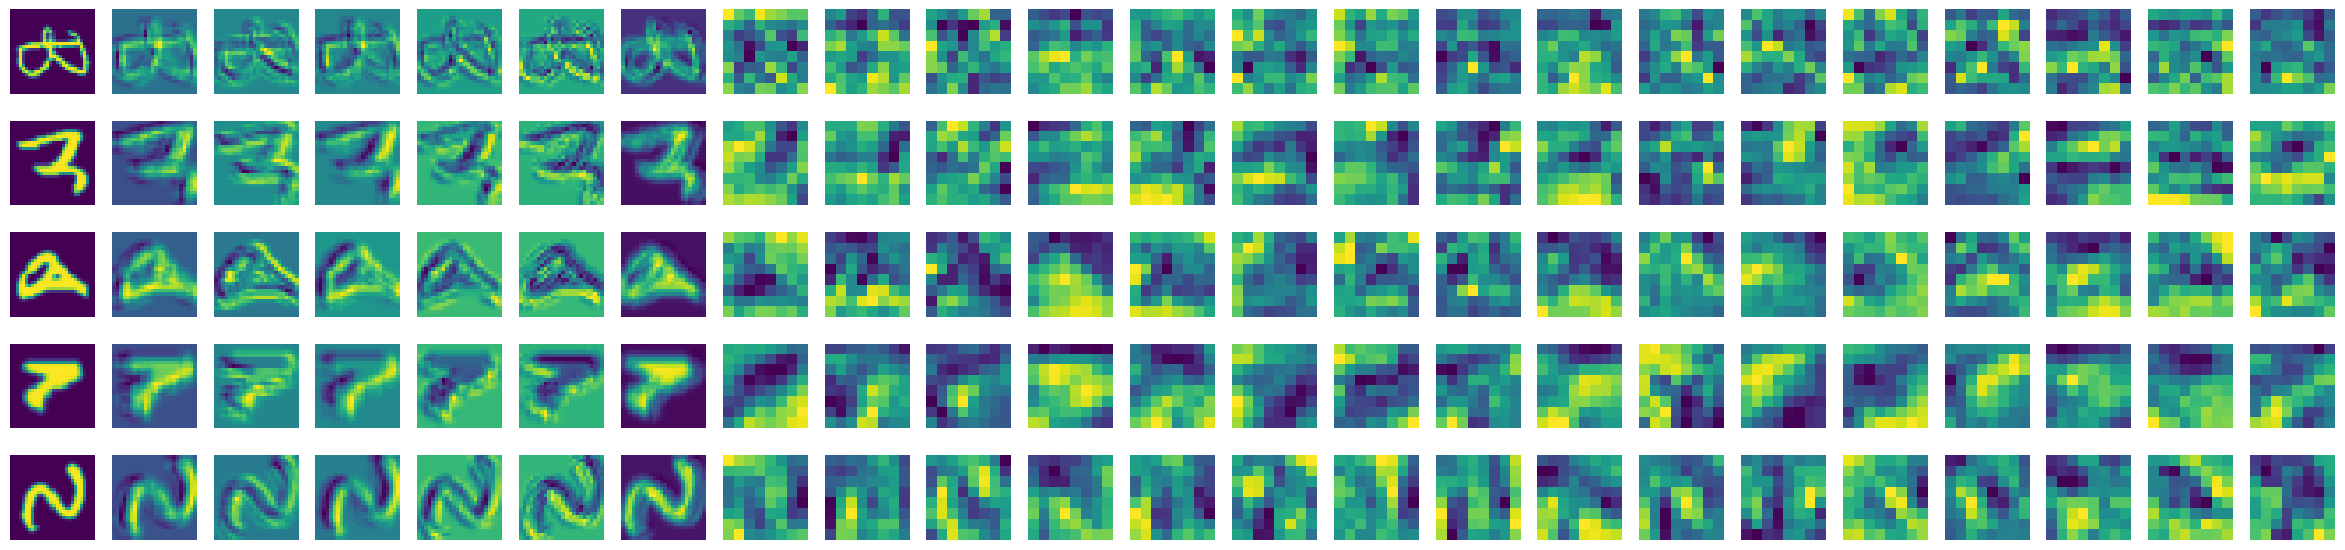

In [36]:
x = x_batch[-5:]
y = model3.layers.conv1(x)
z = model3.layers.conv2(model3.layers.pool1(model3.layers.relu1(y)))

show_layers(x, y, z)

In [37]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model3,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

In [38]:
x_batch = approx_loss(model3, EMNIST_test)

loss: 0.36751815837163193


## Картиночки после обучения, model3


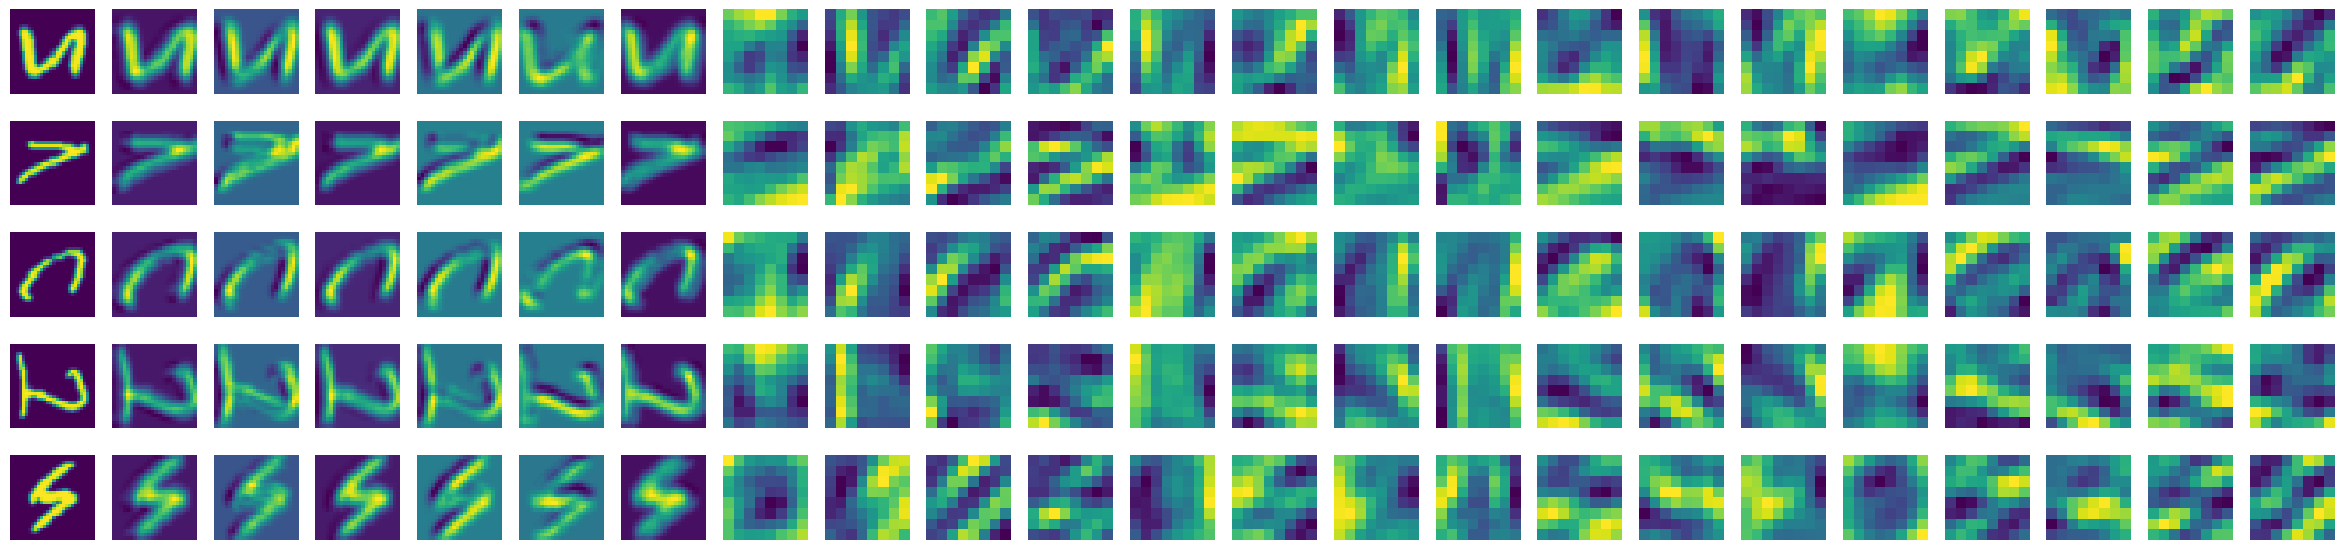

In [39]:
x = x_batch[-5:]
y = model3.layers.conv1(x)
z = model3.layers.conv2(model3.layers.pool1(model3.layers.relu1(y)))

show_layers(x, y, z)

## Модель 4
Добавим BatchNorm после каждой свертки.



In [40]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 3))
layers.add_module('BatchNorm1', torch.nn.BatchNorm2d(1*6, eps=1e-05))
layers.add_module('relu1', torch.nn.ReLU())
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 3))
layers.add_module('BatchNorm2', torch.nn.BatchNorm2d(1*16, eps=1e-05))
layers.add_module('relu2', torch.nn.ReLU())
layers.add_module('conv3', torch.nn.Conv2d(1*16, 2*16, kernel_size = 3))
layers.add_module('BatchNorm3', torch.nn.BatchNorm2d(2*16, eps=1e-05))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(15488, 120))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu5', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model4 = CNN(layers)
model4.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=15488, out_features=120, bias=True)
    (relu4): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu5): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )
)

In [42]:
x_batch = approx_loss(model4, EMNIST_test)

loss: 3.3056012909228984


## Картиночки до обучения, model4

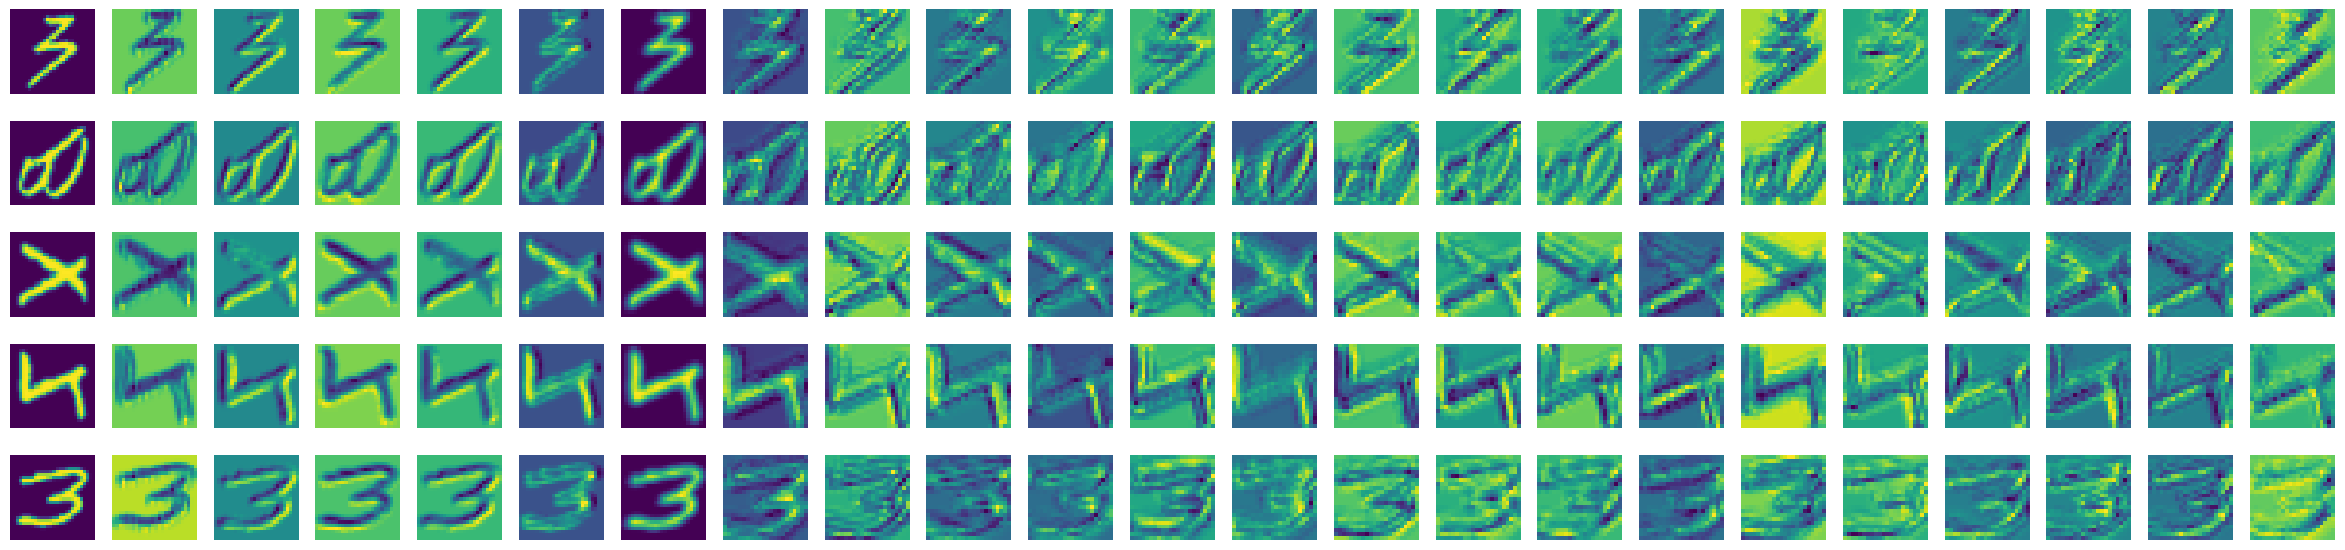

In [43]:
x = x_batch[-5:]
y = model4.layers.conv1(x)
z = model4.layers.conv3(model4.layers.relu2(model4.layers.BatchNorm2(model4.layers.conv2(model4.layers.relu1(model4.layers.BatchNorm1(y))))))

show_layers(x, y, z)

In [44]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model4,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

In [45]:
x_batch = approx_loss(model4, EMNIST_test)

loss: 0.28814441754267767


## Картиночки после обучения, model4


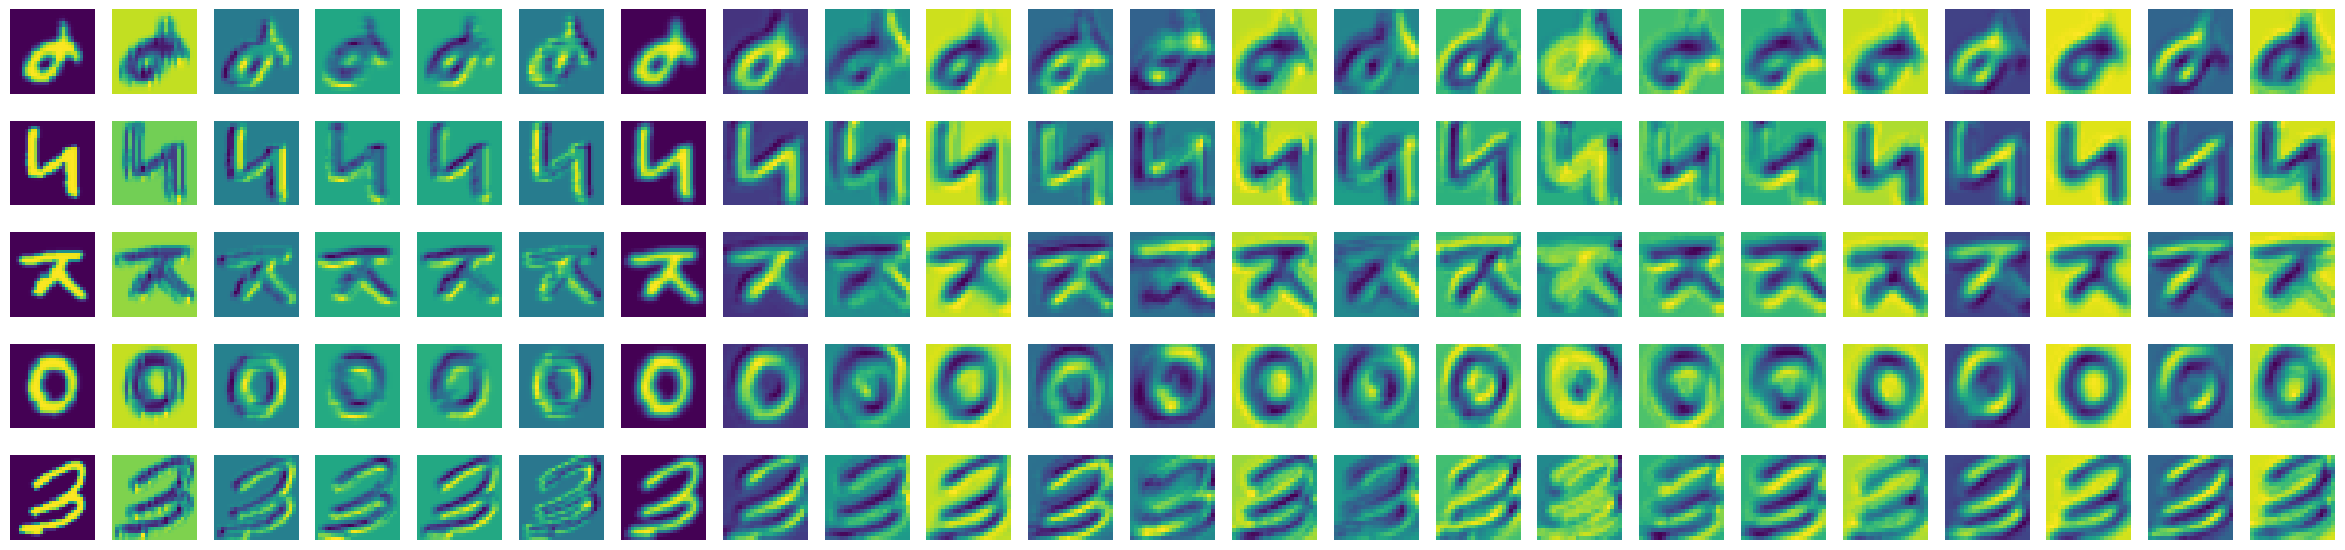

In [46]:
x = x_batch[-5:]
y = model4.layers.conv1(x)
z = model4.layers.conv3(model4.layers.relu2(model4.layers.conv2(model4.layers.relu1(y))))

show_layers(x, y, z)

## Модель 5
Добавим dropout. Не уверена куда именно его надо воткнуть. Сначала я решила, что пусть будет после функций активации раз уж его цель занулить некоторые веса, поставила вероятность 0.3. Потом получила ухудшение качества предыдущей модели и очень шумные картинки в слоях. Следовательно, либо вероятность надо ставить меньше, либо не ставить его часто. Решила проверить первое, поставила вероятность 0.1.



In [55]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

layers = torch.nn.Sequential()
layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 3))
layers.add_module('BatchNorm1', torch.nn.BatchNorm2d(1*6, eps=1e-05))
layers.add_module('relu1', torch.nn.ReLU())
layers.add_module('dropout1', torch.nn.Dropout(p=0.1))
layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 3))
layers.add_module('BatchNorm2', torch.nn.BatchNorm2d(1*16, eps=1e-05))
layers.add_module('relu2', torch.nn.ReLU())
layers.add_module('dropout2', torch.nn.Dropout(p=0.1))
layers.add_module('conv3', torch.nn.Conv2d(1*16, 2*16, kernel_size = 3))
layers.add_module('BatchNorm3', torch.nn.BatchNorm2d(2*16, eps=1e-05))
layers.add_module('relu3', torch.nn.ReLU())
layers.add_module('dropout3', torch.nn.Dropout(p=0.1))
layers.add_module('flatten', torch.nn.Flatten())
layers.add_module('linear1', torch.nn.Linear(15488, 120))
layers.add_module('relu4', torch.nn.ReLU())
layers.add_module('linear2', torch.nn.Linear(120, 84))
layers.add_module('relu5', torch.nn.ReLU())
layers.add_module('linear3', torch.nn.Linear(84, 27))

model5 = CNN(layers)
model5.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (BatchNorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.1, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=15488, out_features=120, bias=True)
    (relu4): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu5): ReLU()
    (linear3): Linear(in_features=84, out_features=27, bias=True)
  )

In [56]:
x_batch = approx_loss(model5, EMNIST_test)

loss: 3.2992352412297175


## Картиночки до обучения, model4

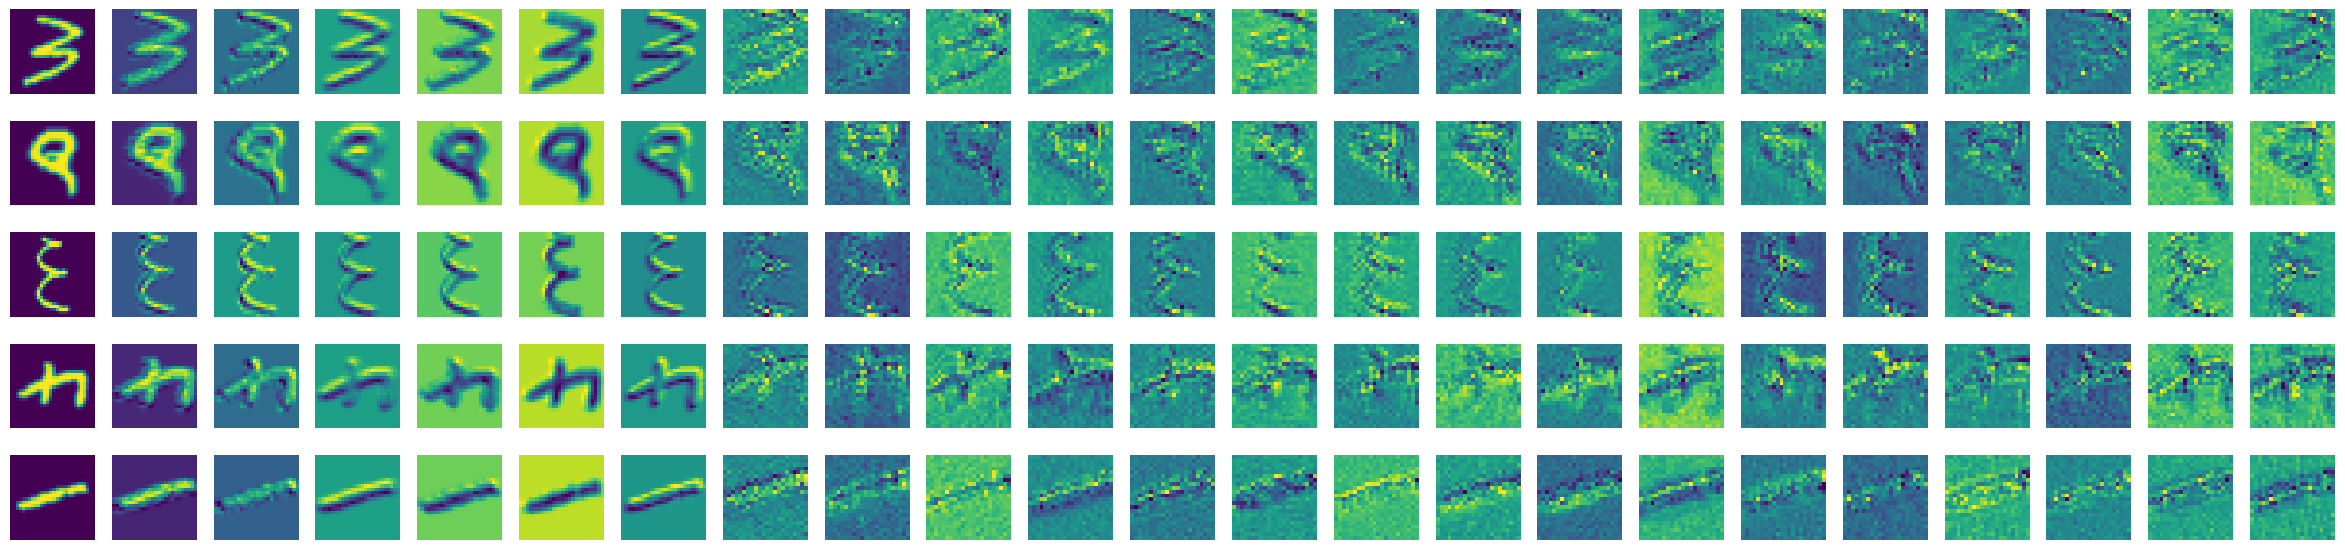

In [57]:
x = x_batch[-5:]
y = model5.layers.conv1(x)
z = model5.layers.conv3(model5.layers.dropout2(model5.layers.relu2(model5.layers.BatchNorm2(model5.layers.conv2(model5.layers.dropout1(model5.layers.relu1(model5.layers.BatchNorm1(y))))))))

show_layers(x, y, z)

In [58]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = EMNIST_train,
        model = model5,### Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1950 [00:00<?, ?it/s]

In [61]:
x_batch = approx_loss(model5, EMNIST_test)

loss: 0.2850447592597741


## Картиночки после обучения, model4


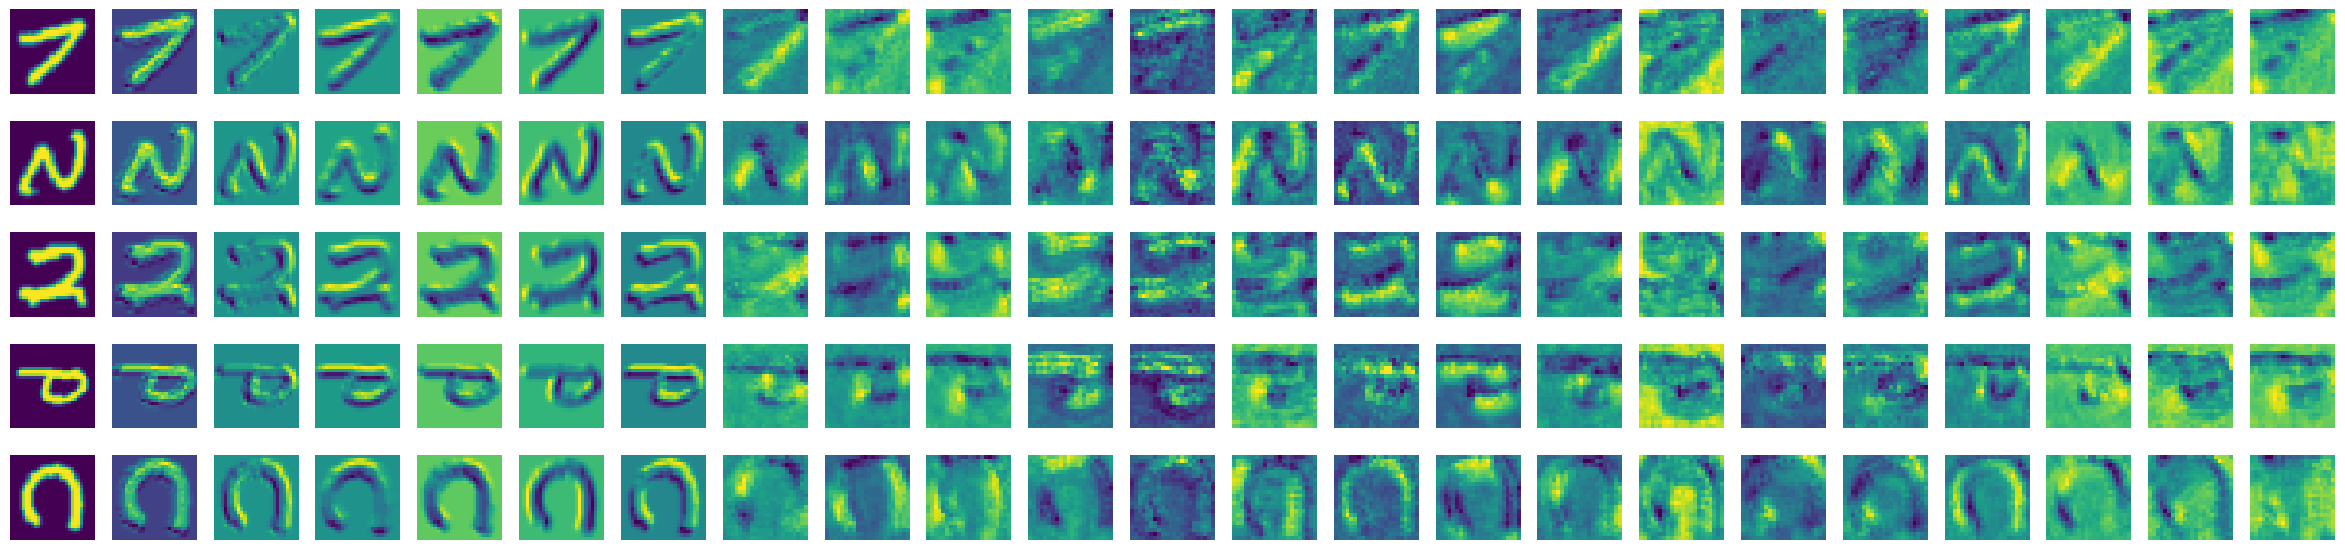

In [60]:
x = x_batch[-5:]
y = model5.layers.conv1(x)
z = model5.layers.conv3(model5.layers.dropout2(model5.layers.relu2(model5.layers.BatchNorm2(model5.layers.conv2(model5.layers.dropout1(model5.layers.relu1(model5.layers.BatchNorm1(y))))))))

show_layers(x, y, z)

# Вывод


1.   Лучшее качесво получилось после уменьшения ядра свертки, добавления еще одной свертки, добавления batchnorm и dropout.
2.   В процесее выполнения были попытки добавить в свертки stride=2, в результате, видимо, терялась нужная в данно случае информация, и качество становилось хуже.
3.   С параметром dropout надо быть осторожнее, но судя по тому, что качество немного улучшилось, отвечает он только за переобучение, а делает немного лучше.
4.  С добавлением maxpooling ситуация получалась похожая на добавление stride=2. Видимо, терялось достаточно важаной информации и качество модели ухудшалось. Однако обучение было быстрее, что логично, ведь количство весов уменьшилось.
5.  Ранее мне не приходилось работать с pytorch, теперь я примерно представляю как с ним иметь дело, хотя меня раздражает недостаточность документации, не самая удобная для понимания (а возможно я просто пока еще глупый).


